# Imports

In [1]:
import re
import string
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from bs4 import BeautifulSoup
from transformers import BertTokenizer, TFBertModel

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

2023-03-04 22:29:22.068588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/satwiktanwar/opt/anaconda3/envs/deep-learning-tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_LEN = 200
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Data Preprocessing

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [6]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [7]:
def restoreList(item):
  item=item.replace("[","")
  item=item.replace("]","")
  item=item.replace("'","")
  item=item.replace("'","")
  item=item.replace(" ","")
  return item.split(',')

In [8]:
def dataPreProcess(dataset):
  data=pd.read_csv(dataset)
  data['Mapped Emotions']=data['Mapped Emotions'].apply(restoreList)

  data['anger'] = np.zeros((len(data),1))
  data['love'] = np.zeros((len(data),1))
  data['fear'] = np.zeros((len(data),1))
  data['joy'] = np.zeros((len(data),1))
  data['sadness'] = np.zeros((len(data),1))
  data['surprise'] = np.zeros((len(data),1))
  data['neutral'] = np.zeros((len(data),1))

  for i in ['anger', 'love', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    data[i] = data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

  data=data[data['neutral']==0]
  data.drop(['Mapped Emotions','neutral'], axis=1, inplace=True)
  data['Text'] = data['Text'].apply(text_preprocessing_pipeline)
  data = data.reset_index(drop=True)

  return data


In [10]:
df_train=dataPreProcess("../rawData/train.csv")
df_dev=dataPreProcess("../rawData/val.csv")
df_test=dataPreProcess("../rawData/test.csv")

In [12]:
df_dev.head()

,Text,anger,love,fear,joy,sadness,surprise
0,i talked to my parents about the fact that i w...,0,1,0,0,0,0
1,i love truck drivers,0,1,0,0,0,0
2,only a sith deals in absolutesfuck that guy,1,0,0,0,0,0
3,im betraying my youth and class origins here b...,0,0,1,0,0,0
4,msaysrawr points at the gear question i just p...,1,0,0,0,0,0


In [13]:
df_test.head()

,Text,anger,love,fear,joy,sadness,surprise
0,so fuckin tired did not get home till,0,0,0,0,1,0
1,filthy birdbrain loving scum barely deserve th...,1,0,0,0,0,0
2,arghhhmy korean dvd cannot seei need to laugh,0,0,0,0,0,1
3,co workers last day we are going to miss her,0,0,0,0,1,0
4,everyones probs already said it but lats and c...,0,0,0,1,0,0


# Tokenization

In [14]:
target_cols = [col for col in df_train.columns if col not in ['Text', 'ID']]
target_cols

['anger', 'love', 'fear', 'joy', 'sadness', 'surprise']

In [15]:
def convert_examples_to_features(df,tokenizer=tokenizer ,max_seq_length=MAX_LEN):

    input_ids,attention_masks,token_type_ids ,labels=[], [], [], []
    text=df.Text
    labels=df[target_cols].values
    length=len(df)
    for i in text:
        input_dict = tokenizer.encode_plus(
            i,
            add_special_tokens=True,
            max_length=max_seq_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )
        in_id=input_dict["input_ids"]
        input_ids.append(in_id)
        attention_mask=input_dict['attention_mask']
        attention_masks.append(attention_mask)
        token_type_id=input_dict["token_type_ids"]
        token_type_ids.append(token_type_id)
    
    
     
    return (
        np.array(input_ids),
        np.array(attention_masks),
        np.array(token_type_ids),
        np.array(labels),
    )

In [16]:
# Convert to features
(train_input_ids, train_attention_masks, train_token_type_ids, train_labels) = convert_examples_to_features(df_train)
(validation_input_ids, validation_attention_masks, validation_token_type_ids, validation_labels) = convert_examples_to_features(df_dev)
(test_input_ids, test_attention_masks, test_token_type_ids, test_labels) = convert_examples_to_features(df_test)

In [17]:
train_labels

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

# Attention Layer

In [3]:
class SeqWeightedAttention(tf.keras.layers.Layer):
    r"""Y = \text{softmax}(XW + b) X
    See: https://arxiv.org/pdf/1708.00524.pdf
    """

    def __init__(self, use_bias=True, return_attention=False, **kwargs):
        super(SeqWeightedAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.use_bias = use_bias
        self.return_attention = return_attention
        self.W, self.b = None, None

    def get_config(self):
        config = {
            'use_bias': self.use_bias,
            'return_attention': self.return_attention,
        }
        base_config = super(SeqWeightedAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        self.W = self.add_weight(shape=(int(input_shape[2]), 1),
                                 name='{}_W'.format(self.name),
                                 initializer=tf.keras.initializers.get('uniform'))
        if self.use_bias:
            self.b = self.add_weight(shape=(1,),
                                     name='{}_b'.format(self.name),
                                     initializer=tf.keras.initializers.get('zeros'))
        super(SeqWeightedAttention, self).build(input_shape)

    def call(self, x, mask=None):
        logits = tf.keras.backend.dot(x, self.W)
        if self.use_bias:
            logits += self.b
        x_shape = tf.keras.backend.shape(x)
        logits = tf.keras.backend.reshape(logits, (x_shape[0], x_shape[1]))
        ai = tf.keras.backend.exp(logits - tf.keras.backend.max(logits, axis=-1, keepdims=True))
        if mask is not None:
            mask = tf.keras.backend.cast(mask, tf.keras.backend.floatx())
            ai = ai * mask
        att_weights = ai / (tf.keras.backend.sum(ai, axis=1, keepdims=True) + tf.keras.backend.epsilon())
        weighted_input = x * tf.keras.backend.expand_dims(att_weights)
        result = tf.keras.backend.sum(weighted_input, axis=1)
        #if self.return_attention:
        #    return att_weights
        return result, att_weights, weighted_input

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return input_shape[0], output_len

    def compute_mask(self, _, input_mask=None):
        if self.return_attention:
            return [None, None]
        return None

    @staticmethod
    def get_custom_objects():
        return {'SeqWeightedAttention': SeqWeightedAttention}

# Model

In [4]:
def create_model():

  ## Inputs
  input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), name="input_ids", dtype=tf.int32)
  attention_masks = tf.keras.layers.Input(shape=(MAX_LEN,), name="attention_masks", dtype=tf.int32)
  token_type_ids = tf.keras.layers.Input(shape=(MAX_LEN,), name="token_type_ids", dtype=tf.int32)

  # BERT encoder
  encoder = TFBertModel.from_pretrained("bert-base-uncased") 
  embedding = encoder(
      input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks
  )[0]


  [attn, attn_w, weighted_input] = SeqWeightedAttention(
                                          return_attention=True)(embedding, mask=attention_masks)

  midLayer=keras.layers.Dropout(0.2)(attn)

  # midLayer=keras.layers.Dense(400,activation='elu',kernel_initializer="he_normal")(midLayer)
  midLayer=keras.layers.BatchNormalization()(midLayer)

  ## Classification Output Layer
  probabilities = keras.layers.Dense(6, activation='softmax')(midLayer)


  ## Model
  model = keras.Model(
      inputs=[input_ids, attention_masks, token_type_ids],
      outputs=[probabilities],
  )
  loss="categorical_crossentropy"
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5)
  model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])

  return model

In [ ]:

model = create_model()
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 200)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True)
model.fit(
    [train_input_ids, train_attention_masks, train_token_type_ids],train_labels,
    validation_data=([validation_input_ids, validation_attention_masks, validation_token_type_ids], validation_labels),
    epochs=10,callbacks=[early_stopping_cb,checkpoint_cb])

Epoch 1/10


1308/1308 [==============================] - 287s 149ms/step - loss: 1.4497 - accuracy: 0.5424 - val_loss: 0.9550 - val_accuracy: 0.7518
Epoch 2/10
1308/1308 [==============================] - 139s 106ms/step - loss: 1.0514 - accuracy: 0.6991 - val_loss: 0.9183 - val_accuracy: 0.7718
Epoch 3/10
1308/1308 [==============================] - 139s 107ms/step - loss: 0.9289 - accuracy: 0.7376 - val_loss: 0.8242 - val_accuracy: 0.7860
Epoch 4/10
1308/1308 [==============================] - 136s 104ms/step - loss: 0.8399 - accuracy: 0.7645 - val_loss: 0.8711 - val_accuracy: 0.7871
Epoch 5/10
1308/1308 [==============================] - 136s 104ms/step - loss: 0.7787 - accuracy: 0.7848 - val_loss: 0.9493 - val_accuracy: 0.7891
Epoch 6/10
1308/1308 [==============================] - 136s 104ms/step - loss: 0.7336 - accuracy: 0.7991 - val_loss: 0.9427 - val_accuracy: 0.7918
Epoch 7/10
1308/1308 [==============================] - 144s 110ms/step - loss: 0.6882 - accuracy: 0.8143 - val_loss: 1.002

In [ ]:
model.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels)

194/194 [==============================] - 8s 38ms/step - loss: 0.8840 - accuracy: 0.7693


[0.8840444087982178, 0.769329845905304]

# Predictions

In [5]:
emotionsModel=create_model()
emotionsModel.load_weights('model.h5')

2023-03-04 22:29:40.725906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model che

In [ ]:
def convertSentence(text,tokenizer=tokenizer ,max_seq_length=MAX_LEN):  
  input_ids,attention_masks,token_type_ids =[], [], []
  i=text
  input_dict = tokenizer.encode_plus(
          i,
          add_special_tokens=True,
          max_length=max_seq_length, # truncates if len(s) > max_length
          return_token_type_ids=True,
          return_attention_mask=True,
          padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
          truncation=True
      )
  in_id=input_dict["input_ids"]
  input_ids.append(in_id)
  attention_mask=input_dict['attention_mask']
  attention_masks.append(attention_mask)
  token_type_id=input_dict["token_type_ids"]
  token_type_ids.append(token_type_id)
      
    
    
     
  return (
    np.array(input_ids),
    np.array(attention_masks),
    np.array(token_type_ids),
  )

In [ ]:
def predictEmotion(model):
  sen=str(input("Enter a sentence: "))
  sen = " ".join(sen.split())
  (sen_input_ids, sen_attention_masks, sen_token_type_ids)=convertSentence(sen)

  emotionsList=['anger', 'love', 'fear', 'joy', 'sadness', 'surprise']

  preds=model.predict([sen_input_ids, sen_attention_masks, sen_token_type_ids])
  emotionIndex=np.where(preds[0]==preds[0].max())[0][0]

  print("\nEmotion: ",emotionsList[emotionIndex],"\n")

  get_att_w = tf.keras.backend.function(model.input, model.layers[4].output )

  o,a,wx = get_att_w([sen_input_ids, 
               sen_attention_masks, 
               sen_token_type_ids])
  a_score=a[a!=0][1:-1]

  plt.rcParams["figure.figsize"] = 10,5

  fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

  ax.imshow(a_score[np.newaxis,:], cmap="Reds", aspect="auto")
  ax.set_yticks([])

  ax2.plot(a_score)
  plt.grid()
  plt.tight_layout()

  plt.show()


Enter a sentence: I went to the movie theatre to watch a movie only to discover that tickets were not available
1/1 [==============================] - 3s 3s/step

Emotion:  sadness 



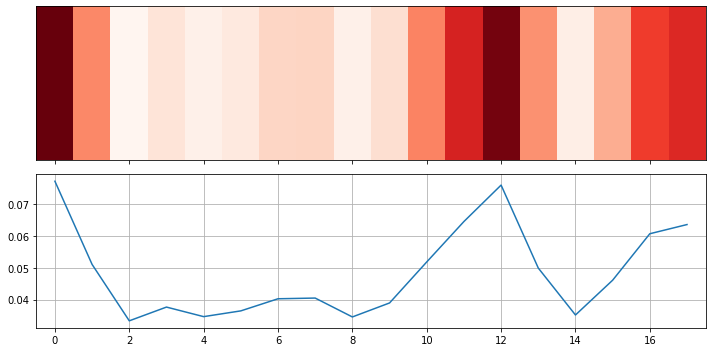

In [ ]:
predictEmotion(emotionsModel)